In [0]:
import array
import gzip
import itertools
import numpy
import numpy.random as npr
import os
import struct
import time
from os import path
import urllib.request
from matplotlib import pyplot as plt

import jax.numpy as np
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
from jax import random

In [0]:
_DATA = "/tmp/"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(create_outliers=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  test_images = _partial_flatten(test_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if create_outliers:
    mum_outliers = 30000
    perm = numpy.random.RandomState(0).permutation(mum_outliers)
    train_images[:mum_outliers] = train_images[:mum_outliers][perm]

  return train_images, train_labels, test_images, test_labels

def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels

train_images, train_labels, test_images, test_labels = mnist(create_outliers=False)
num_train = train_images.shape[0]

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

def init_random_params(layer_sizes, rng=npr.RandomState(0)):
  scale = 0.1
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

In [0]:
batch_size = 128

# num complete batches = 468
# leftover = 96
# num_train = 60,000
# num_batches = 469 = num_training / batch_size = 60,000/128 = 469
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

# gets the next batch of data
batches = data_stream()

# **Assignment 4: CNN**

Before we get started, we need to import two small libraries that contain boilerplate code for common neural network layer types and for optimizers like mini-batch SGD.

In [0]:
from jax.experimental import optimizers
from jax.experimental import stax

Here is a fully-connected neural network architecture, like the one of Problem 1, but this time defined with `stax`

In [0]:
# modified network to achieve 99% accuracy
init_random_params, predict = stax.serial(
    stax.Conv(128, (5,5), strides = (2,2)),
    stax.Relu,
    stax.MaxPool((2,2), (1,1)),
    stax.Conv(64, (5,5), strides = (2,2)),
    stax.Relu,
    stax.MaxPool((2,2), (1,1)),
    stax.Flatten,
    stax.Dense(256),
    stax.Relu,
    stax.Dense(64),
    stax.Relu,
    stax.Dense(10)
)

We redefine the cross-entropy loss for this model. As done in Problem 1, complete the return line below (it's identical). 

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.sum(targets*preds)/len(targets)

Next, we define the mini-batch SGD optimizer, this time with the optimizers library in JAX. 

In [0]:
learning_rate = 0.22
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

The next cell contains our training loop, very similar to Problem 1. 

In [9]:
num_epochs = 15

key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))
opt_state = opt_init(init_params)
itercount = itertools.count()

test_accuracy = []

for epoch in range(1, num_epochs + 1):
  for _ in range(num_batches):
    opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

  params = get_params(opt_state)
  test_acc = accuracy(params, shape_as_image(test_images, test_labels))
  test_accuracy.append(float(test_acc))
  test_loss = loss(params, shape_as_image(test_images, test_labels))
  # print('Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(test_loss, 100 * test_acc))
  print('Test set accuracy (%): ({:.2f})'.format(100 * test_acc))

Test set accuracy (%): (98.15)
Test set accuracy (%): (98.97)
Test set accuracy (%): (99.03)
Test set accuracy (%): (98.84)
Test set accuracy (%): (99.06)
Test set accuracy (%): (99.15)
Test set accuracy (%): (99.25)
Test set accuracy (%): (98.73)
Test set accuracy (%): (98.58)
Test set accuracy (%): (99.19)
Test set accuracy (%): (99.11)
Test set accuracy (%): (97.65)
Test set accuracy (%): (99.00)
Test set accuracy (%): (99.09)
Test set accuracy (%): (99.20)


# **Assignment 5: Adversarial Examples**

Find an image showing 7 in the test set.

In [0]:
# array representing 7
seven_array = np.array([0.,0.,0.,0.,0.,0.,0.,1.,0.,0.])

seven_list = []

# create a list of indexes where the number 7 exists
for i in range(len(test_labels)):
  if np.all(test_labels[i] == seven_array):
    seven_list.append(i)

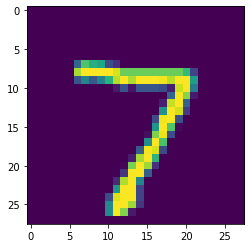

In [11]:
# visualize a particular image
visualize_image = test_images[seven_list[0]]
visualize_image = np.reshape(visualize_image, (28,28))
plt.figure(1)
plt.imshow(visualize_image, interpolation='nearest')
plt.show()

In [0]:
# batch = shape_as_image(test_images, test_labels)
# # inputs.shape = (10000, 28, 28, 1), targets.shape = (10000, 10)
# # inputs[0].shape = (28, 28, 1)
# # targets[0].shape = (10,1)
# inputs, targets = batch

In [0]:
# # calculate adversarial loss
# def loss_adv(input_image, target):
#   logits = predict(params, input_image)
#   preds  = stax.logsoftmax(logits)
#   return -np.sum(target*preds)/len(target)

## Question 1

### 1) Find Perturbation

In [0]:
from jax.experimental.stax import logsoftmax

In [0]:
# reshape image to fit original inputs dimension
seven = np.reshape(test_images[seven_list[0]], (1,28,28,1))

In [0]:
# calculate adversarial loss
def loss_adv(input_image, target):
  logits = predict(params, input_image)
  return -np.sum(logsoftmax(logits)*target)/len(target)

# calculate the gradient of adversarial loss with respect to input
gradient = grad(loss_adv, (0))
grads = gradient(seven, test_labels[seven_list[0]])

In [0]:
# reshape
seven_image = np.reshape(seven, (28,28))
noise_image = np.reshape(grads, (28,28))

# get perturbation
perturbation = 0.3*np.sign(noise_image)

### 2) Visualize Perturbed Image

In [0]:
# get adversarial example
perturbed_image = seven_image + perturbation

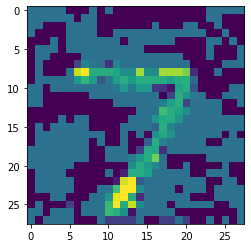

In [19]:
# plot the perturbed image
plt.figure(2)
plt.imshow(perturbed_image, interpolation='nearest')
plt.show()

### 3) Prediction Vector Output of Original and Perturbed Image

In [20]:
# check prediction of perturbed image
seven_image_ = np.reshape(seven_image, (1,28,28,1))
logits = predict(params, seven_image_)
preds  = stax.logsoftmax(logits)
print("Prediction of Original Image: ", int(np.argmax(preds)))
print("Prediction (vector) of Original Image: ", preds)
print()

# check prediction of perturbed image
perturbed_image_ = np.reshape(perturbed_image, (1,28,28,1))
logits = predict(params, perturbed_image_)
preds  = stax.logsoftmax(logits)
print("Prediction of Perturbed Image: ", int(np.argmax(preds)))
print("Prediction (vector) of Perturbed Image: ", preds)

Prediction of Original Image:  7
Prediction (vector) of Original Image:  [[-2.0806259e+01 -1.8431292e+01 -1.8775633e+01 -1.7268757e+01
  -1.6481335e+01 -2.0463610e+01 -2.6512928e+01 -2.3841855e-07
  -2.2024256e+01 -1.5572758e+01]]

Prediction of Perturbed Image:  7
Prediction (vector) of Perturbed Image:  [[-6.6563435 -3.5949972 -0.9271786 -2.402524  -3.836224  -5.328535
  -5.7546873 -0.8647044 -3.5187502 -5.362487 ]]


## Question 2

In [0]:
# get the first 1000 test image and labels
test_img = test_images[:1000] # shape (1000,784)
test_lb = test_labels[:1000] # shape (1000,10)

# reshape image from 784 to 28 x 28
reshaped_test_img = np.reshape(test_img, (1000, 28, 28, 1))

# take gradient of all 1000 images and labels
grads = gradient(reshaped_test_img, test_lb) # grads.shape = (1000, 28, 28, 1)

In [0]:
# generate a set of perturbed images (shape = (1000,28,28,1))
perturbed_imgs = reshaped_test_img + 0.3*np.sign(grads)

In [0]:
# calculate accuracy of the generated perturbed imgs with epsilon = 0.3
test_acc = accuracy(params, shape_as_image(perturbed_imgs, test_lb))

### Plot Epsilon vs Accuracy

In [0]:
# generate a list of epsilons for plotting
epsilon_list = np.arange(0, 2, 0.01).tolist()

In [0]:
accuracy_list = []

for eps in epsilon_list:
  perturbed_imgs = reshaped_test_img + eps*np.sign(grads)
  test_acc = accuracy(params, shape_as_image(perturbed_imgs, test_lb))
  accuracy_list.append(float(test_acc))

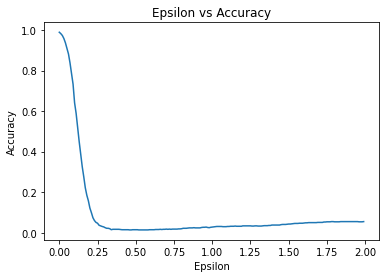

In [26]:
# plot epsilon vs accuracy
plt.figure(3)
plt.plot(epsilon_list, accuracy_list)
plt.title('Epsilon vs Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

## Question 3

### 1) Code to find the Perturbation (Iteratively)

In [0]:
# reshape image to fit original inputs dimension
seven = np.reshape(test_images[seven_list[0]], (1,28,28,1))

# make a copy of original image
seven_original = seven

# use a small hyperparamter that is roughly epsilon/k where k = 5
epsilon = 0.3/5

for k in range(1, 6):

  # calculate the gradient of adversarial loss with respect to input
  gradient = grad(loss_adv, (0))
  grads = gradient(seven, test_labels[seven_list[0]])

  # reshape to (28,28)
  seven_image = np.reshape(seven, (28,28))
  noise_image = np.reshape(grads, (28,28))

  # perturbate the image
  perturbation = epsilon*np.sign(noise_image)
  perturbed_image = seven_image + perturbation

  # carry the perturbed image in to the next iteration
  seven_image = perturbed_image
  seven = np.reshape(seven_image, (1,28,28,1))

### 2) Visualize the Perturbed Image

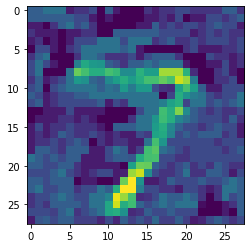

In [54]:
# show iteratively perturbed image
plt.figure(4)
plt.imshow(perturbed_image, interpolation='nearest')
plt.show()

### 3) Prediction Vector of Original and Perturbed Image

In [50]:
# check prediction of perturbed image
seven_image_ = seven_original
logits = predict(params, seven_image_)
preds  = stax.logsoftmax(logits)
print("Prediction of Original Image: ", int(np.argmax(preds)))
print("Prediction (vector) of Original Image: ", preds)
print()

# check prediction of perturbed image
perturbed_image_ = np.reshape(perturbed_image, (1,28,28,1))
logits = predict(params, perturbed_image_)
preds  = stax.logsoftmax(logits)
print("Prediction of Perturbed Image: ", int(np.argmax(preds)))
print("Prediction (vector) of Perturbed Image: ", preds)

Prediction of Original Image:  7
Prediction (vector) of Original Image:  [[-2.0806259e+01 -1.8431292e+01 -1.8775633e+01 -1.7268757e+01
  -1.6481335e+01 -2.0463610e+01 -2.6512928e+01 -2.3841855e-07
  -2.2024256e+01 -1.5572758e+01]]

Prediction of Perturbed Image:  9
Prediction (vector) of Perturbed Image:  [[-1.3933599e+01 -1.5307801e+01 -1.8578835e+01 -8.4177923e+00
  -1.1439633e+01 -1.0069764e+01 -1.6172129e+01 -8.2007065e+00
  -1.1121210e+01 -5.6465418e-04]]


## Question 4

In [0]:
# generate a list of epsilons for plotting
epsilon_list = np.arange(0, 2, 0.01).tolist()

In [0]:
# get the first 1000 test image and labels
test_img = test_images[:1000] # shape (1000,784)
test_lb = test_labels[:1000] # shape (1000,10)

# reshape image from (1000, 784) to (1000, 28, 28, 1)
reshaped_test_img = np.reshape(test_img, (1000, 28, 28, 1))

In [0]:
accuracy_list = []

for eps in epsilon_list:

  # use a small hyperparamter that is roughly epsilon/k where k = 5
  epsilon = eps/5

  # iteratively perturb the image over 5 steps
  for k in range(1, 6):

    # calculate the gradient of adversarial loss with respect to input
    gradient = grad(loss_adv, (0))
    grads = gradient(reshaped_test_img, test_lb)

    # get perturbed imgs
    perturbed_imgs = reshaped_test_img + epsilon*np.sign(grads)

    # carry the perturbed image in to the next iteration
    reshaped_test_img = perturbed_imgs

  # calculate test acc of perturbed imgs
  test_acc = accuracy(params, shape_as_image(perturbed_imgs, test_lb))
  accuracy_list.append(float(test_acc))

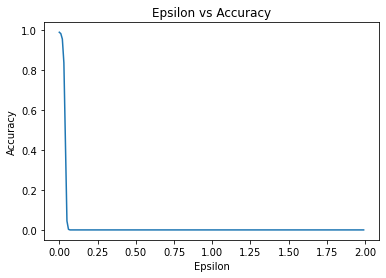

In [70]:
# plot epsilon vs accuracy
plt.figure(5)
plt.plot(epsilon_list, accuracy_list)
plt.title('Epsilon vs Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()